In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

 Activating environment at `~/Research/RegressionPPC/Project.toml`


In [35]:
using LaTeXStrings
using Logging
using Random
using ReverseDiff
using StatsPlots
using Turing

The true distribution we will be using for generating the data is:
$$
q \sim \mathrm{Beta}\left( 1, 1 \right)
$$
(that is: flat in $0 < q < 1$), 
$$
\left. y \mid q \right. \sim N\left( a \left( q - 1/2 \right), \sigma \right)
$$
with 
$$
a = -0.4
$$
and
$$
\sigma = 0.1
$$

Observations will be independently noised, with 
$$
\left. q_\mathrm{obs} \mid q \right. \sim N\left( q , \sigma_q \right)
$$
with 
$$
\sigma_q = 0.25
$$
(so that the amount of excess scatter in $y$ induced by the uncertainty in $q$ for the right model is $\Delta y \simeq \left| a \right| \sigma_q \simeq \sigma$ and 
$$
\left. y_\mathrm{obs} \mid y \right. \sim N\left( y, \sigma_y \right)
$$
with 
$$
\sigma_\mathrm{obs} = \frac{\left| a \right|}{2}.
$$
This ensures that the measurement uncertainty is comparable to the offset in the mean at the extreme ends of the regression relationship.  

First, a useful helper function for seeding the RNG:

In [8]:
"""
    with_seed(f, seed)

Evaluate the zero-argument function `f` in an environment where `Random.GLOBAL_RNG` has been seeded with the given seed.  When `f` returns or if control exits abnormally, the RNG is re-seeded randomly.

Note the useful syntax 

    with_seed(SEED_VALUE) do 
        # Do stuff
    end
"""
function with_seed(f, seed)
    Random.seed!(seed)
    try
        f()
    finally
        Random.seed!()
    end
end

with_seed

Now we draw:

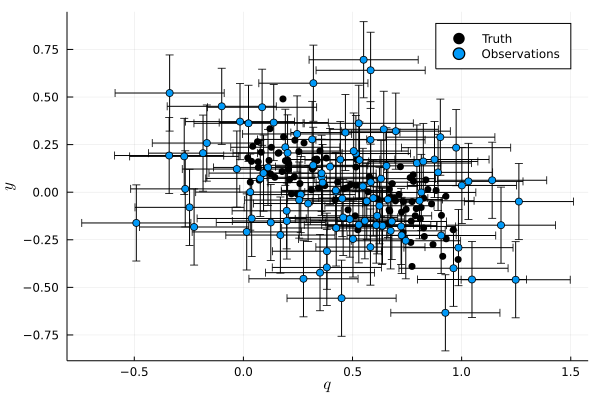

In [31]:
N = 100

alpha_true = 1.0
beta_true = 1.0
a_true = -0.4
sigma_true = 0.1

sigma_y = abs(a_true)/2
sigma_q = 1/4

q_trues, y_trues, q_obs, y_obs = with_seed(5120325801443553697) do 
    q_trues = rand(Beta(alpha_true, beta_true), N)
    y_trues = [rand(Normal(a_true*(q-1/2), sigma_true)) for q in q_trues]
    
    q_obs = [rand(Normal(q, sigma_q)) for q in q_trues]
    y_obs = [rand(Normal(y, sigma_obs)) for y in y_trues]
    
    (q_trues, y_trues, q_obs, y_obs)
end

scatter(q_trues, y_trues, markerstrokewidth=0, color=:black, label="Truth", xlabel=L"q", ylabel=L"y")
scatter!(q_obs, y_obs, yerr=sigma_y, xerr=sigma_q, label="Observations", color=1)

First we fit these to a (bad) model where $q$ and $y$ are independent, beta and normally distributed.

In [32]:
@model function bad_model(q_obs, y_obs)
    N = length(q_obs)
    
    beta_mean ~ Uniform(0.1,0.9) # alpha / (alpha + beta)
    beta_counts ~ LogNormal(log(2), 1) # alpha + beta
    
    alpha = beta_mean * beta_counts
    beta = (1-beta_mean) * beta_counts
    
    mu_y ~ Normal(0, 1)
    sigma_y ~ truncated(Normal(0, 1), 0, Inf)
    
    q_true ~ filldist(Beta(alpha, beta), N)
    
    y_true_unit ~ filldist(Normal(0,1), N)
    y_true = mu_y .+ y_true_unit.*sigma_y
    
    q_obs ~ arraydist([Normal(q, sigma_q) for q in q_true])
    y_obs ~ arraydist([Normal(y, sigma_y) for y in y_true])
    
    # Ignore the derivatives for these generated quantities---this is a hack, but I guess necessary.
    qs_gen = rand(Beta(ReverseDiff.value(alpha), ReverseDiff.value(beta)), N)
    ys_gen = rand(Normal(ReverseDiff.value(mu_y), ReverseDiff.value(sigma_y)), N)
    
    # Return a named tuple of generated quantities
    return (alpha=alpha, beta=beta, y_true=y_true, qs_gen=qs_gen, ys_gen=ys_gen)
end

bad_model (generic function with 1 method)

In [33]:
Turing.setadbackend(:reversediff)
bm = bad_model(q_obs, y_obs)
btrace = sample(bm, NUTS(), 1000, progress=true)
btrace[[:beta_mean, :beta_counts, :mu_y, :sigma_y]] # Only print summary of the population parameters

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/Gntg0/src/inference/hmc.jl:188
Sampling:  10%|████                                     |  ETA: 0:02:38┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/wfarr/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  16%|██████▋                                  |  ETA: 0:01:43┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/wfarr/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:42


Chains MCMC chain (1000×4×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = beta_counts, beta_mean, mu_y, sigma_y
internals         = 

Summary Statistics
   parameters      mean       std   naive_se      mcse         ess      rhat 
       Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

  beta_counts    2.4744    0.7435     0.0235    0.0619    163.5757    1.0041
    beta_mean    0.4535    0.0367     0.0012    0.0011    914.1036    0.9996
         mu_y    0.0157    0.0265     0.0008    0.0008    976.4393    0.9994
      sigma_y    0.1855    0.0127     0.0004    0.0004   1184.5537    1.0031

Quantiles
   parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
       Symbol   Float64   Float64   Float64   Float64   Float64 

  beta_counts    1.3515    1.9356    2.3564    2.8955    4.1383
    beta_mean    0.3844    0.4290    0.4531    0.4789    0.5244
         mu_y   -0.033

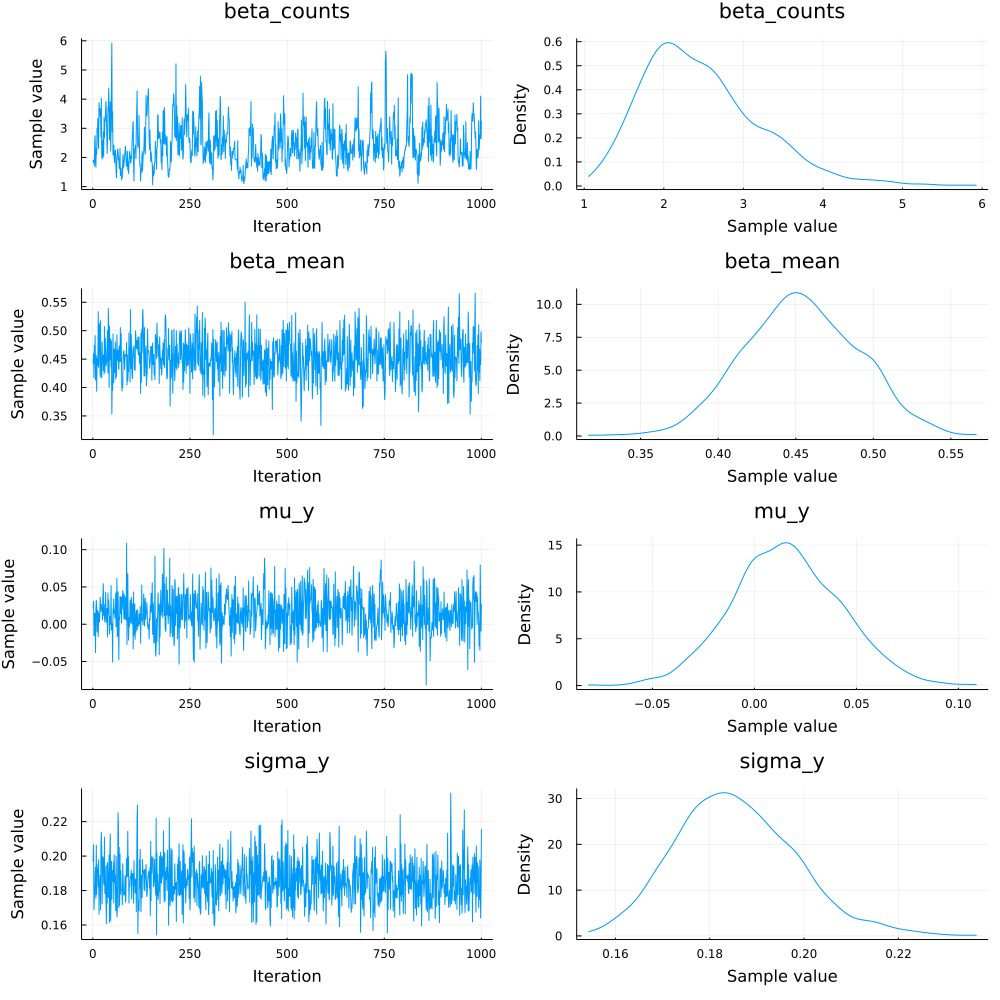

In [70]:
plot(btrace, [:beta_counts, :beta_mean, :mu_y, :sigma_y])

In [73]:
bgenq = with_logger(NullLogger()) do # We get a lot of warnings!
    generated_quantities(bm, btrace)
end;

It looks like the hierarchical fit for $q$ is pretty good:

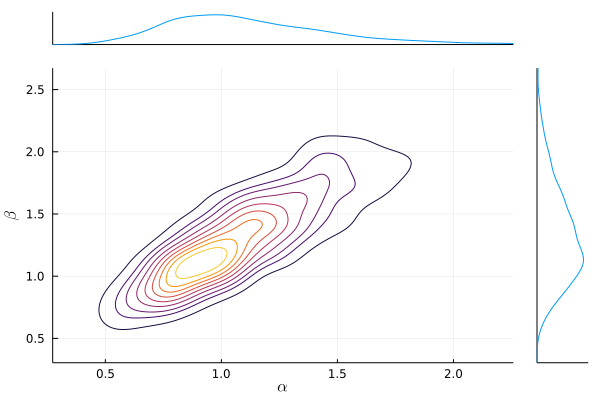

In [75]:
marginalkde([x.alpha for x in bgenq], [x.beta for x in bgenq], xlabel=L"\alpha", ylabel=L"\beta")

The parameters for the $y$ distribution are junk, but at least reasonable (note that $\sigma$ is inflated over the true scatter because the model expands to account for the span of true values induced by the linear relationship).

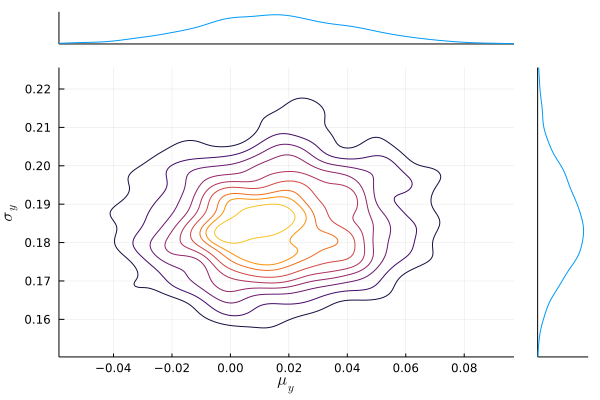

In [76]:
@df btrace marginalkde(:mu_y, :sigma_y, xlabel=L"\mu_y", ylabel=L"\sigma_y")

Nothing really looks out of place if we plot the inferred distributions of truth on top of fair draws from the model:

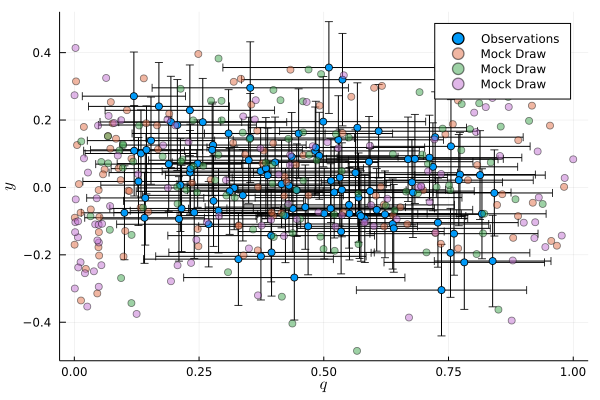

In [77]:
p = scatter([mean(btrace[Symbol("q_true[$i]")]) for i in 1:N], [mean([x.y_true[i] for x in bgenq]) for i in 1:N],
            xerr=[std(btrace[Symbol("q_true[$i]")]) for i in 1:N], yerr=[std([x.y_true[i] for x in bgenq]) for i in 1:N], 
            label="Observations",
            xlabel=L"q", ylabel=L"y")
for j in 1:3
    g = sample(bgenq)
    p = scatter!(g.qs_gen, g.ys_gen, label="Mock Draw", alpha=0.5)
end
p

Let's fit a linear model to the inferred $ys$ as a function of $q$:

In [58]:
function linear_slope(qs, ys)
    N = length(qs)
    
    M = hcat(ones(N), (qs .- 1/2))
    
    (M \ ys)[2]
end

linear_slope (generic function with 1 method)

In [78]:
obs_slopes = [linear_slope([btrace[Symbol("q_true[$k]")][i,j] for k in 1:N], bgenq[i,j].y_true) for i in 1:size(btrace,1), j in size(btrace,3)]
draw_slopes = [linear_slope(g.qs_gen, g.ys_gen) for g in bgenq];

There is *some* preference for the slope of the inferred truth to be smaller than the draw, but it is not super significant:

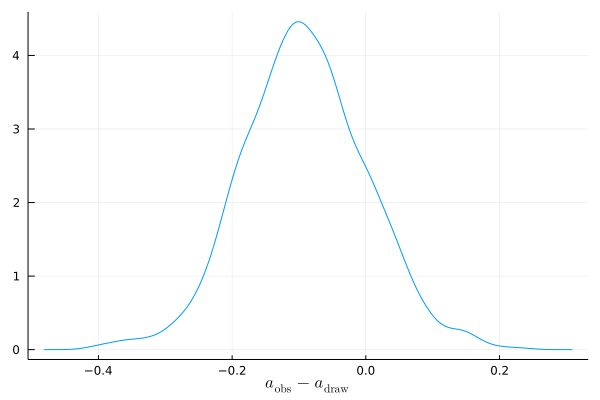

In [79]:
density(obs_slopes .- draw_slopes, xlabel=L"a_\mathrm{obs} - a_\mathrm{draw}", legend=nothing)

The distributions of slopes look offset, though:

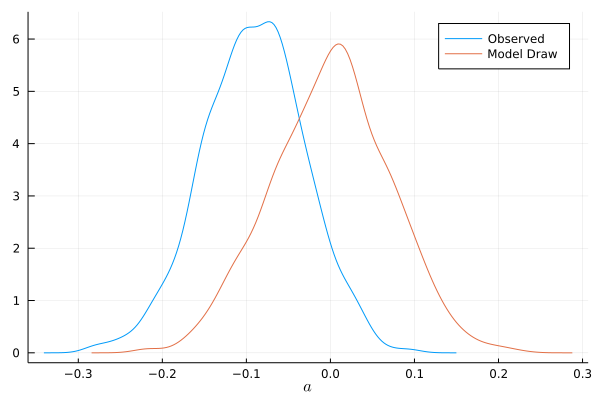

In [80]:
density(obs_slopes, xlabel=L"a", label="Observed")
density!(draw_slopes, label="Model Draw")

Now what happens if we fit a correct model?

In [87]:
@model function model(q_obs, y_obs)
    N = length(q_obs)
    
    beta_mean ~ Uniform(0.1,0.9) # alpha / (alpha + beta)
    beta_counts ~ LogNormal(log(2), 1) # alpha + beta
    
    alpha = beta_mean * beta_counts
    beta = (1-beta_mean) * beta_counts
    
    mu_y ~ Normal(0,1)
    a_y ~ Normal(0,1)
    sigma_y ~ truncated(Normal(0, 1), 0, Inf)
    
    q_true ~ filldist(Beta(alpha, beta), N)
    
    y_true_unit ~ filldist(Normal(0,1), N)
    y_true = mu_y .+ a_y.*(q_true .- 1/2) .+ y_true_unit.*sigma_y
    
    q_obs ~ arraydist([Normal(q, sigma_q) for q in q_true])
    y_obs ~ arraydist([Normal(y, sigma_y) for y in y_true])
    
    # Ignore the derivatives for these generated quantities---this is a hack, but I guess necessary.
    qs_gen = rand(Beta(ReverseDiff.value(alpha), ReverseDiff.value(beta)), N)
    ys_gen = [rand(Normal(ReverseDiff.value(mu_y + a_y*(q-1/2)), ReverseDiff.value(sigma_y))) for q in qs_gen]
    
    # Return a named tuple of generated quantities
    return (alpha=alpha, beta=beta, y_true=y_true, qs_gen=qs_gen, ys_gen=ys_gen)
end

model (generic function with 1 method)

In [88]:
m = model(q_obs, y_obs)
trace = sample(m, NUTS(), 1000, progress=true)
trace[[:beta_mean, :beta_counts, :mu_y, :a_y, :sigma_y]]

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/wfarr/.julia/packages/Turing/Gntg0/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:02:51


Chains MCMC chain (1000×5×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = a_y, beta_counts, beta_mean, mu_y, sigma_y
internals         = 

Summary Statistics
   parameters      mean       std   naive_se      mcse         ess      rhat 
       Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

          a_y   -0.3361    0.1293     0.0041    0.0082    235.8216    1.0057
  beta_counts    2.4960    0.7686     0.0243    0.0833     94.6977    1.0165
    beta_mean    0.4513    0.0352     0.0011    0.0017    690.6468    1.0026
         mu_y    0.0001    0.0274     0.0009    0.0008   1043.6910    0.9993
      sigma_y    0.1747    0.0134     0.0004    0.0006    854.2506    0.9991

Quantiles
   parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
       Symbol   Float64   Float64   Float64   Float64   Float64 

          a_y   -0.6002   -0.4168   -0.3330   -0.2495   -0.1017
  be

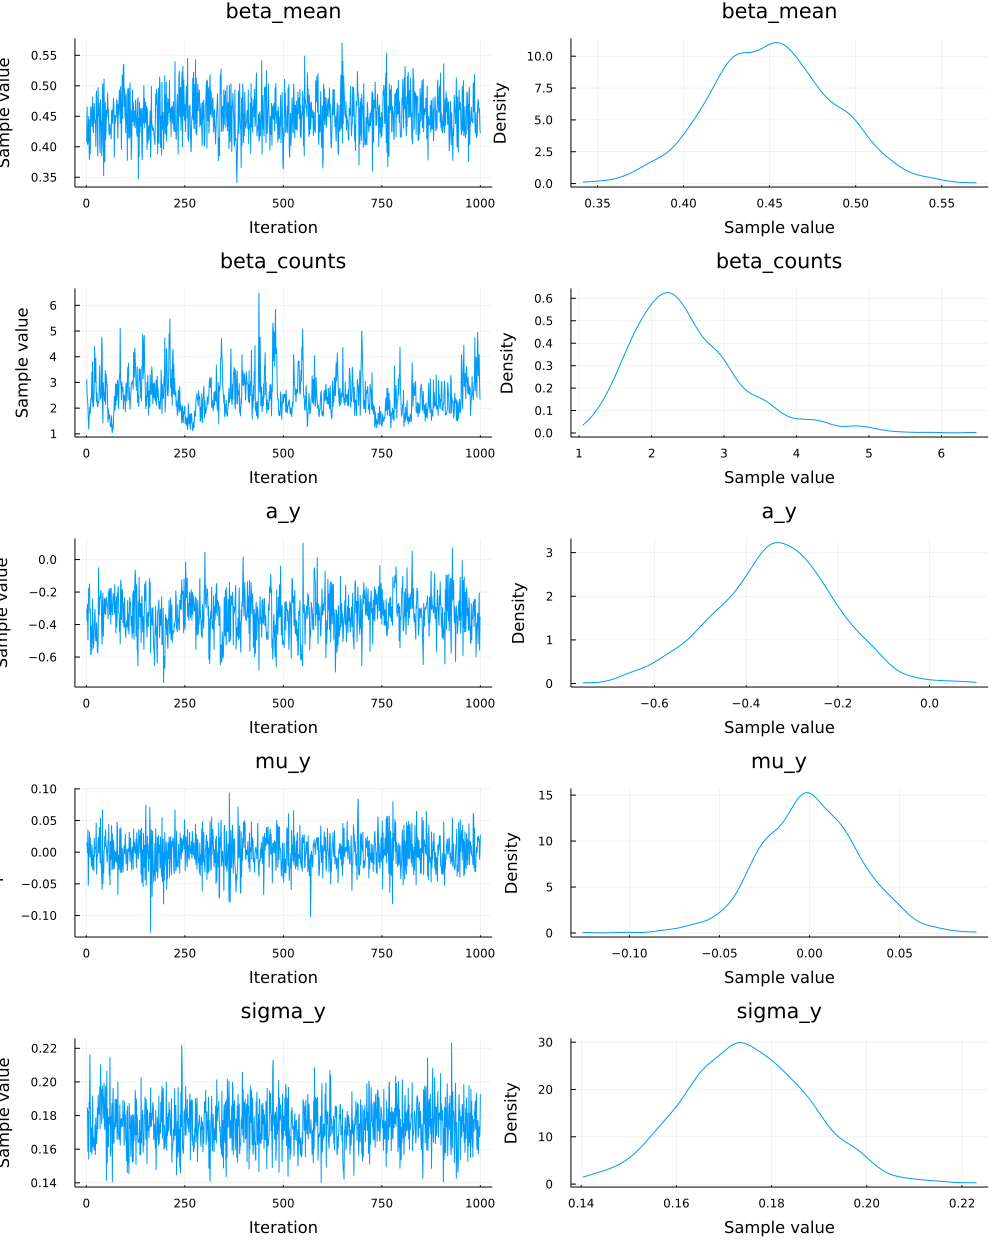

In [89]:
plot(trace, [:beta_mean, :beta_counts, :a_y, :mu_y, :sigma_y])

Note that we find very strong evidence of a linear relationship (black line is truth):

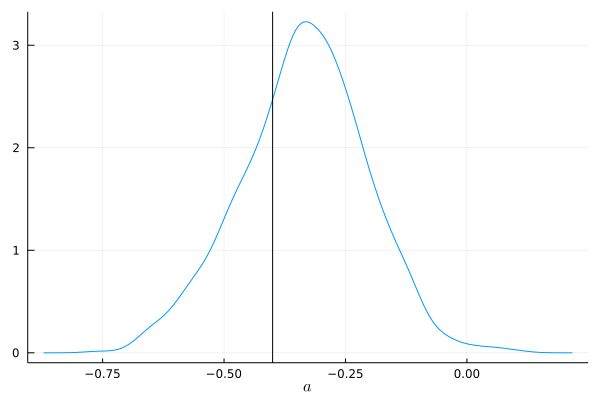

In [90]:
@df trace density(:a_y, legend=nothing, xlabel=L"a")
vline!([a_true], color=:black)

In [91]:
genq = with_logger(NullLogger()) do 
    generated_quantities(m, trace)
end;

How about if we plot truth and draws?  Looks cool, again:

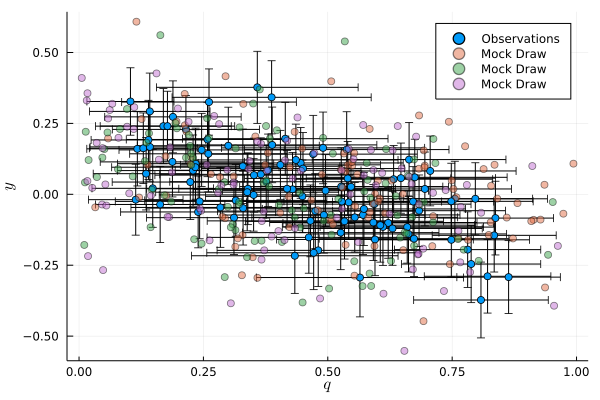

In [92]:
p = scatter([mean(trace[Symbol("q_true[$i]")]) for i in 1:N], [mean([x.y_true[i] for x in genq]) for i in 1:N],
            xerr=[std(trace[Symbol("q_true[$i]")]) for i in 1:N], yerr=[std([x.y_true[i] for x in genq]) for i in 1:N], 
            label="Observations",
            xlabel=L"q", ylabel=L"y")
for j in 1:3
    g = sample(genq)
    p = scatter!(g.qs_gen, g.ys_gen, label="Mock Draw", alpha=0.5)
end
p

Here are the slopes:

In [93]:
obs_slopes = [linear_slope([trace[Symbol("q_true[$k]")][i,j] for k in 1:N], genq[i,j].y_true) for i in 1:size(trace,1), j in size(trace,3)]
draw_slopes = [linear_slope(g.qs_gen, g.ys_gen) for g in genq];

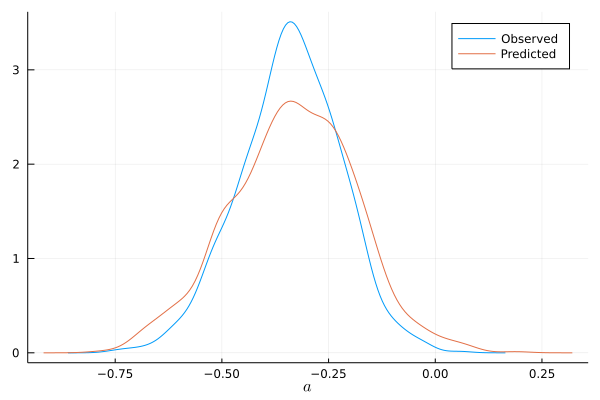

In [94]:
density(obs_slopes, label="Observed", xlabel=L"a")
density!(draw_slopes, label="Predicted")